# 7.4 Exercises




## Exercise 1

The [LRASPP model](https://pytorch.org/vision/stable/models/lraspp.html) is a proposed network for embedded devices, such as smartphones.
The architecture is based on [MobileNet](https://arxiv.org/abs/1905.02244) and combines bilinear interpolation and convolutional layers to increase prediction sampling without increasing complexity, as shown below.

Given the characteristics of this architecture, it is expected that it will generate slightly worse results but with greater speed. Check if this is true by fine-tuning and comparing both accuracy and processing time with the model previously trained in this practice.

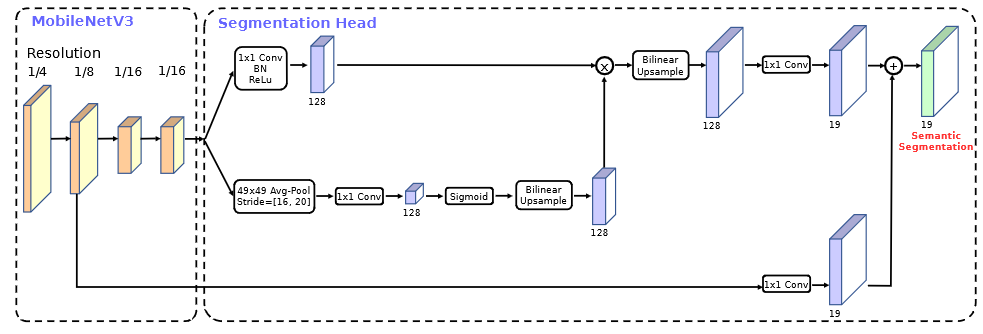



### Preparing the data

In [ ]:
# install d2l
!pip install -U d2l
from d2l import torch as d2l

In [ ]:
# import some basic libaries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from sklearn.metrics import accuracy_score
import cv2
from PIL import Image
from tqdm import tqdm
import warnings
import os

In [ ]:
d2l.DATA_HUB['voc2012'] = (d2l.DATA_URL + 'VOCtrainval_11-May-2012.tar',
                           '4e443f8a2eca6b1dac8a6c57641b67dd40621a49')

voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')

In [ ]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

def read_voc_images(voc_dir, is_train=True):
    """Read all VOC images and label them"""
    txt_fname = os.path.join(voc_dir, 'ImageSets', 'Segmentation',
                             'train.txt' if is_train else 'val.txt')
    mode = torchvision.io.image.ImageReadMode.RGB # Read RGB images
    with open(txt_fname, 'r') as f:
        filenames = f.read().split() # image name
    images, labels = [], []
    for i, fname in enumerate(filenames):
        images.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'JPEGImages', f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(
            voc_dir, 'SegmentationClass' ,f'{fname}.png'), mode)) # RGB labels
    return images[:500], labels[:500]

def voc_colormap2label():
    """Build a mapping from RGB to VOC category index (labels)"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        # Convert the index in VOC_COLORMAP to i
        # Change the 256 base to the 10 base
        # Map the i-th RGB value to i
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label # a dict

# Colormap is the RGB value in the image, which is converted into the corresponding label value
def voc_label_indices(colormap, colormap2label):
    """Map RGB values in VOC labels to their category indices"""
    # permute(1, 2, 0) to trans between the channels
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

def voc_rand_crop(image, label, height, width):
    """Randomly crop images and labels"""
    # i,j,h,w get the bounding box ，that is, in which area to crop
    i,j,h,w = transforms.RandomCrop.get_params(
        image, output_size=(height, width))
    image = transforms.functional.crop(image, i,j,h,w)
    label = transforms.functional.crop(label, i,j,h,w)
    return image, label  # cropped images and labels

class VOCSegDataset(torch.utils.data.Dataset):
    """For loading the VOC dataset"""
    def __init__(self, is_train, crop_size, voc_dir):
        self.transform = (
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # normalization
            )
        self.crop_size = crop_size
        # read images
        images, labels = read_voc_images(voc_dir, is_train=is_train)  # 500 images
        self.images = [self.normalize_image(image) for image in self.filter(images)]
        self.labels = self.filter(labels)  # filter is defined later
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.images)) + ' examples')

    def normalize_image(self, img):
        return self.transform(img.float() / 255)  # dividing by 255 and normalize

    def filter(self, imgs):
        # remove the image if the szie is smaller than the area to crop
        # this will probably filter out some images from the 500
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    def __getitem__(self, idx):
        image, label = voc_rand_crop(self.images[idx], self.labels[idx], *self.crop_size)
        return (image, voc_label_indices(label, self.colormap2label))

    def __len__(self):
        return len(self.images)

In [ ]:
batch_size = 16
crop_size = (224, 224)
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

train_loader = torch.utils.data.DataLoader(voc_train, batch_size,
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(voc_test, batch_size, drop_last=True)

### Model

Define your model here.

In [ ]:
# define model here
from torchvision.models.segmentation import lraspp_mobilenet_v3_large

# this is the pre-trained weights we want to use
# this model was pre-trained using a subset of the COCO dataset [https://cocodataset.org/]
# with 21 classes (the same ones of the VOC PASCAL)
model = lraspp_mobilenet_v3_large(pretrained=True)

### Training and Validation

In [ ]:
# multi-classification cross-entropy loss function
lossf = nn.CrossEntropyLoss()

# choose adam optimizer to train
optimizer = optim.SGD(model.parameters(), lr=0.1)

epochs_num = 10

In [ ]:
def train_batch(net, X, y, loss, trainer, device):
    """Train for a minibatch with GPU """
    X = X.to(device)
    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred['out'], y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred['out'], y)
    return train_loss_sum, train_acc_sum

def evaluate(net, test_iter, device):
    net.eval()
    acc = []
    for i, (features, labels) in enumerate(test_iter):
        X = features.to(device)
        pred = net(X)
        soft_outs = F.log_softmax(pred['out'], dim=1)
        pred = soft_outs.cpu().data.numpy().argmax(axis=1)  # argmax preserves the index of the maximum value
        acc.append(accuracy_score(labels.flatten(), pred.flatten()))
    return sum(acc)/len(acc)

def train(net, train_iter, test_iter, loss, trainer, num_epochs):
    #Train a model using GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    timer, num_batches = d2l.Timer(), len(train_iter)

    net = net.to(device)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_loader):
            timer.start()
            l, acc = train_batch(net, features, labels.long(), loss, trainer, device)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()

        test_acc = evaluate(net, test_iter, device)
        print(f'epoch {epoch+1} -- '
              f'loss {metric[0] / metric[2]:.3f}, train acc '
              f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f} ------ '
              f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
              f'{str(device)}')

# this process is very time consuming, please use the gpu to improve the efficiency.
train(model, train_loader, test_loader, lossf, optimizer, epochs_num)

## Exercise 2

As seen during the talks, [Faster R-CNN](https://arxiv.org/abs/1506.01497) is a two-stage object detector, that tends to have a longer runtime but produce better results.
On the other hand, [Single Shot Detector (SSD)](https://arxiv.org/abs/1512.02325) is a one-stage detector that tends to be faster to run, however, produces slightly worse results.

Check whether this difference between one- and two-stage detectors is true by fine-tuning and comparing the SSD model (in terms of processing time) with the model previously trained in this practice.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import sys
import time
import datetime
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict, deque
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Dataset

First, you need to download the Aquarium dataset in Kaggle:
https://www.kaggle.com/datasets/sharansmenon/aquarium-dataset.
After that, you have two options: upload it into Colab or into your Google Drive, as before.

If needed, you can use the cell below to unzip the files. Adjust it if necessary.


In [ ]:
!unzip archive.zip

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [ ]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

# load classes
dataset_path="Aquarium Combined"
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

In [ ]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

### Model

Implement your model here.

In [ ]:
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDHead

# Load the pre-trained SSD model
model = ssd300_vgg16(pretrained=True)

num_anchors = model.anchor_generator.num_anchors_per_location()
in_features = []
for i in range(len(model.head.classification_head.module_list)):
  in_features.append(model.head.classification_head.module_list[i].in_channels)

new_classification_head = SSDHead(in_features, num_anchors, n_classes)

# Replace the old classification head with the new one
model.head = new_classification_head

model = model.to(device)

### Training

In [ ]:
# parameters and optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses)
    ))

In [ ]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)